In [1]:
# Core NLP & ML libraries
!pip install -q transformers datasets torch scikit-learn matplotlib seaborn


In [2]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from datasets import load_dataset
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer
)
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report


In [3]:
dataset = load_dataset("tweet_eval", "sentiment")

dataset


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

sentiment/train-00000-of-00001.parquet:   0%|          | 0.00/3.78M [00:00<?, ?B/s]

sentiment/test-00000-of-00001.parquet:   0%|          | 0.00/901k [00:00<?, ?B/s]

sentiment/validation-00000-of-00001.parq(…):   0%|          | 0.00/167k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/45615 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/12284 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2000 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 45615
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 12284
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

In [4]:
label_names = {0: "Negative", 1: "Neutral", 2: "Positive"}


In [11]:
MODEL_NAME = "distilbert-base-uncased"


tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

def tokenize_batch(batch):
    return tokenizer(
        batch["text"],
        padding="max_length",
        truncation=True,
        max_length=64
    )

tokenized_dataset = dataset.map(tokenize_batch, batched=True)
tokenized_dataset = tokenized_dataset.rename_column("label", "labels")
tokenized_dataset.set_format("torch")



Map:   0%|          | 0/45615 [00:00<?, ? examples/s]

Map:   0%|          | 0/12284 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [12]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModelForSequenceClassification.from_pretrained(
    "bert-base-uncased",
    num_labels=3
)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [13]:
training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=1,
    weight_decay=0.01,
    logging_dir="./logs",
    load_best_model_at_end=True,
    report_to="none"
)


In [14]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=1)
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc}


In [15]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["validation"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

trainer.train()


/tmp/ipython-input-3092314375.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.590700,0.598637,0.738500


TrainOutput(global_step=2851, training_loss=0.648370743466862, metrics={'train_runtime': 547.4629, 'train_samples_per_second': 83.321, 'train_steps_per_second': 5.208, 'total_flos': 1500239818707840.0, 'train_loss': 0.648370743466862, 'epoch': 1.0})

In [16]:
predictions = trainer.predict(tokenized_dataset["test"])
y_true = predictions.label_ids
y_pred = np.argmax(predictions.predictions, axis=1)

print(classification_report(
    y_true,
    y_pred,
    target_names=label_names.values()
))


              precision    recall  f1-score   support

    Negative       0.70      0.75      0.72      3972
     Neutral       0.73      0.65      0.69      5937
    Positive       0.64      0.75      0.69      2375

    accuracy                           0.70     12284
   macro avg       0.69      0.72      0.70     12284
weighted avg       0.70      0.70      0.70     12284



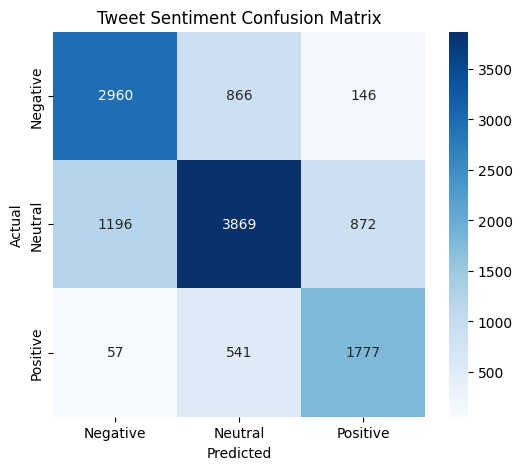

In [17]:
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6,5))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=label_names.values(),
    yticklabels=label_names.values()
)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Tweet Sentiment Confusion Matrix")
plt.show()


In [18]:
misclassified = np.where(y_true != y_pred)[0]

for idx in misclassified[:5]:
    print("Text ID:", idx)
    print("True:", label_names[y_true[idx]])
    print("Pred:", label_names[y_pred[idx]])
    print("-" * 50)


Text ID: 0
True: Neutral
Pred: Negative
--------------------------------------------------
Text ID: 2
True: Neutral
Pred: Negative
--------------------------------------------------
Text ID: 4
True: Negative
Pred: Neutral
--------------------------------------------------
Text ID: 5
True: Neutral
Pred: Negative
--------------------------------------------------
Text ID: 8
True: Neutral
Pred: Negative
--------------------------------------------------
